In [1]:
!pip install pandas scikit-learn matplotlib

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [3]:
import pandas as pd
import numpy as np
from string import punctuation
from sklearn.model_selection import train_test_split
from collections import Counter
import matplotlib.pyplot as plt
%matplotlib inline

## Классификация

Данные возьмем из соревнования - https://www.kaggle.com/c/quora-insincere-questions-classification/overview  
В этом соревновании нужно было предсказывать токсичность вопроса.

In [4]:
quora = pd.read_csv('quora.csv')

In [5]:
quora

,qid,question_text,target
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0
...,...,...,...
1306117,ffffcc4e2331aaf1e41e,What other technical skills do you need as a c...,0
1306118,ffffd431801e5a2f4861,Does MS in ECE have good job prospects in USA ...,0
1306119,ffffd48fb36b63db010c,Is foam insulation toxic?,0
1306120,ffffec519fa37cf60c78,How can one start a research project based on ...,0


Предобработка

In [6]:
def preprocess(text):
    tokens = text.lower().split()
    tokens = [token.strip(punctuation) for token in tokens]
    return tokens

In [7]:
# словарь
vocab = Counter()

for text in quora.question_text:
    vocab.update(preprocess(text))

In [8]:
len(vocab)

273056

In [9]:
# отфильтрованный словарь
filtered_vocab = set()

for word in vocab:
    if vocab[word] > 50:
        filtered_vocab.add(word)

In [10]:
len(filtered_vocab)

14083

In [11]:
# индексируем слова
word2id = {'PAD':0}

for word in filtered_vocab:
    word2id[word] = len(word2id)

In [12]:
id2word = {i:word for word, i in word2id.items()}

In [13]:
MAX_LEN = 100

In [14]:
train_dataset, valid_dataset = train_test_split(quora, test_size=0.05)

In [15]:
class Dataset(torch.utils.data.Dataset):

    def __init__(self, dataset, word2id, MAX_LEN, text_field, target_field):
        
        # храним сырой датасет
        # еще лучше можно сделать, если считывать из файла при генерации
        self.dataset = dataset[text_field].values
        
        # мы не считаем словарь прямо тут, т.к. нам нужно шерить словарь между трейном и валидацией
        self.word2id = word2id
        self.MAX_LEN = MAX_LEN
        self.length = dataset.shape[0]
        # таргеты можно сразу целиком выделить 
        self.target = torch.Tensor(dataset[target_field].values)

    def __len__(self):
        # нужно уметь возвращать длину датасета, в нашем случае это просто сделать
        # если не загружать данные целиком, а читать из файла - это может быть сложнее
        return self.length

    def __getitem__(self, index):

        # в index будут индексы от 0 до self.length
        # по ним мы достанем тексты, предобработаем,переведем в векторы, западим и вернем


        tokens = self.preprocess(self.dataset[index]) # токенизируем
        ids = [self.word2id[token] for token in tokens if token in self.word2id][:MAX_LEN]
        ids = torch.nn.functional.pad(torch.LongTensor(ids), 
                                (0, self.MAX_LEN-len(ids)), 
                                mode='constant',
                                value=0)

        y = self.target[index]

        return ids, y

    def preprocess(self, text):
        tokens = text.lower().split()
        tokens = [token.strip(punctuation) for token in tokens]
        tokens = [token for token in tokens if token]
        return tokens

In [16]:
training_set = Dataset(train_dataset, word2id, MAX_LEN, 'question_text', 'target')
training_generator = torch.utils.data.DataLoader(training_set, batch_size=256)

valid_set = Dataset(valid_dataset, word2id, MAX_LEN, 'question_text', 'target')
valid_generator = torch.utils.data.DataLoader(valid_set, batch_size=256)

Добавим два варианта работы с эмбеддингами


In [17]:
def my_layer(embedding_dim, emb_type):
  if emb_type == 'flatten':
    return (nn.Flatten(), embedding_dim*MAX_LEN)
  if emb_type == 'mean':
    print('mean')
    return (lambda x:torch.mean(x, dim=1), embedding_dim)
  if emb_type == 'sum':
    print('sum')
    return (lambda x:torch.sum(x, dim=1), embedding_dim)

In [18]:
class Clf(nn.Module):
    
    def __init__(self, vocab_size, embedding_dim, output_dim, emb_type='flatten'):
        
        super().__init__()          
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.hidden, linear_input_dim = my_layer(embedding_dim, emb_type)
        self.fc = nn.Linear(linear_input_dim, output_dim)
        self.act = nn.Sigmoid() # активацию менять даже не пришлось, так как у нас бинарная классификация
                                # если классов больше 2, то нужно поставить nn.Softmax()
        
    def forward(self, text):
        
        embedded = self.embedding(text)   
        hidden = self.hidden(embedded)
        dense_outputs=self.fc(hidden)
        outputs=self.act(dense_outputs)
        
        return outputs

In [19]:
def binary_accuracy(preds, y):
    rounded_preds = torch.round(preds)
    
    correct = (rounded_preds == y).float() 
    acc = correct.sum() / len(correct)
    return acc


def train(model, iterator, optimizer, criterion, print_every=1000):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()  

    for i, (texts, ys) in enumerate(iterator):
        
        optimizer.zero_grad()   
        predictions = model(texts.to(device)).squeeze()  
        loss = criterion(predictions.float(), ys.to(device).float())        
        acc = binary_accuracy(predictions.float(), ys.to(device).float())
        loss.backward()     
        
        optimizer.step()      
        
        #лосс и еще и метрика теперь
        epoch_loss += loss.item()  
        epoch_acc += acc.item()
        
        if not (i+1) % print_every:
            print(f'Loss: {epoch_loss/i}; Accuracy: {epoch_acc/i}')
        
    return epoch_acc / len(iterator)


def evaluate(model, iterator, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()  
    with torch.no_grad():
        for texts, ys in iterator:   

            predictions = model(texts.to(device)).squeeze()  
            loss = criterion(predictions.float(), ys.to(device).float())        
            acc = binary_accuracy(predictions.float(), ys.to(device).float())

            epoch_loss += loss.item()  
            epoch_acc += acc.item()
            
    return epoch_acc / len(iterator)

Конкатенация

In [20]:
import torch.optim as optim

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  
model = Clf(len(word2id), 45, 1, emb_type='flatten')

optimizer = optim.Adam(model.parameters())
criterion = nn.BCELoss() # другой лосс - Binary cross-entropy

model = model.to(device)
criterion = criterion.to(device)

In [21]:
%%time
accs = []
accs_eval = []
epochs = 3
for i in range(epochs):
    print(i)
    accs.append(train(model, training_generator, optimizer, criterion))
    accs_eval.append(evaluate(model, valid_generator, criterion))

0
Loss: 0.1801566802435093; Accuracy: 0.9411442692692693
Loss: 0.1641514728655512; Accuracy: 0.9437433560530265
Loss: 0.1558017691062585; Accuracy: 0.9453580881127043
Loss: 0.15000461538166934; Accuracy: 0.9465540213178295
1
Loss: 0.12560437813595132; Accuracy: 0.9533869807307307
Loss: 0.12430867289247484; Accuracy: 0.9531973017758879
Loss: 0.12373657054794196; Accuracy: 0.9532018485328443
Loss: 0.12297759909079384; Accuracy: 0.953419995623906
2
Loss: 0.11903389405321192; Accuracy: 0.9555727602602603
Loss: 0.11843216624213433; Accuracy: 0.954963810030015
Loss: 0.11821667774617374; Accuracy: 0.9548873061853951
Loss: 0.1179854259040243; Accuracy: 0.9549262315578895
CPU times: user 1min 47s, sys: 2.9 s, total: 1min 50s
Wall time: 1min 50s


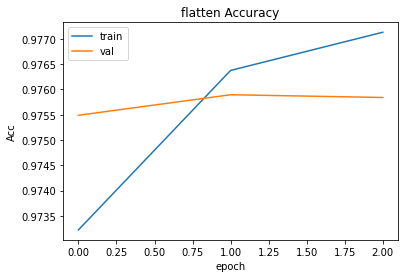

In [22]:
plt.plot(np.sqrt(accs))
plt.plot(np.sqrt(accs_eval))
plt.title('flatten Accuracy')
plt.ylabel('Acc')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [23]:
preds = []
targets = []
for texts, ys in valid_generator:
    preds += model(texts.to(device)).squeeze().detach().to('cpu').numpy().tolist()
    targets += ys.numpy().tolist()

Можно вытащить предикты и посчитать все через sklearn

In [24]:
from sklearn.metrics import classification_report

In [25]:
# можно подбирать порог для отнесения к токсичному классу
print(classification_report(targets, (np.array(preds) > 0.3).astype(int)))

              precision    recall  f1-score   support

         0.0       0.97      0.97      0.97     61262
         1.0       0.60      0.58      0.59      4045

    accuracy                           0.95     65307
   macro avg       0.79      0.78      0.78     65307
weighted avg       0.95      0.95      0.95     65307



Сумма

In [26]:
import torch.optim as optim

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  
model = Clf(len(word2id), 30, 1, emb_type='sum')

optimizer = optim.Adam(model.parameters(), lr=0.0005)
criterion = nn.BCELoss() # другой лосс - Binary cross-entropy

model = model.to(device)
criterion = criterion.to(device)

sum


In [27]:
%%time
accs = []
accs_eval = []
epochs = 3
for i in range(epochs):
    print(i)
    accs.append(train(model, training_generator, optimizer, criterion))
    accs_eval.append(evaluate(model, valid_generator, criterion))

0
Loss: 1.56379077699151; Accuracy: 0.9024024024024024
Loss: 0.8755431717346465; Accuracy: 0.9207181715857929
Loss: 0.6379567945426347; Accuracy: 0.9285048141047015
Loss: 0.5160593876010121; Accuracy: 0.9329510111902976
1
Loss: 0.13893714614279634; Accuracy: 0.9502432119619619
Loss: 0.13696867625800713; Accuracy: 0.9501449943721861
Loss: 0.13566176744849334; Accuracy: 0.9502763942147382
Loss: 0.13427952114258834; Accuracy: 0.9505481839209803
2
Loss: 0.1277107248778219; Accuracy: 0.9530116053553553
Loss: 0.1268081406244133; Accuracy: 0.9527165926713357
Loss: 0.12635078028505267; Accuracy: 0.9526391609703234
Loss: 0.12573109795769086; Accuracy: 0.9527831176544136
CPU times: user 1min 50s, sys: 2.47 s, total: 1min 52s
Wall time: 1min 53s


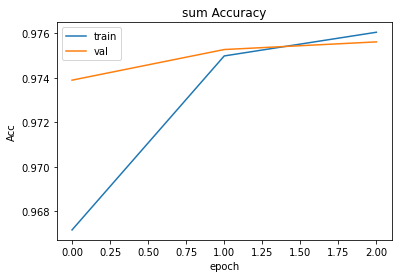

In [28]:
plt.plot(np.sqrt(accs))
plt.plot(np.sqrt(accs_eval))
plt.title('sum Accuracy')
plt.ylabel('Acc')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [29]:
preds = []
targets = []
for texts, ys in valid_generator:
    preds += model(texts.to(device)).squeeze().detach().to('cpu').numpy().tolist()
    targets += ys.numpy().tolist()

In [30]:
# можно подбирать порог для отнесения к токсичному классу
print(classification_report(targets, (np.array(preds) > 0.2).astype(int)))

              precision    recall  f1-score   support

         0.0       0.98      0.96      0.97     61262
         1.0       0.53      0.70      0.61      4045

    accuracy                           0.94     65307
   macro avg       0.76      0.83      0.79     65307
weighted avg       0.95      0.94      0.95     65307



Среднее

In [31]:
import torch.optim as optim

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  
model = Clf(len(word2id), 30, 1, emb_type='mean')

optimizer = optim.Adam(model.parameters())
criterion = nn.BCELoss() # другой лосс - Binary cross-entropy

model = model.to(device)
criterion = criterion.to(device)

mean


In [32]:
%%time
accs = []
accs_eval = []
epochs = 3
for i in range(epochs):
    print(i)
    accs.append(train(model, training_generator, optimizer, criterion))
    accs_eval.append(evaluate(model, valid_generator, criterion))

0
Loss: 0.26696168447101676; Accuracy: 0.911059496996997
Loss: 0.23968203446309289; Accuracy: 0.9247377595047523
Loss: 0.2234105185325164; Accuracy: 0.9294452317439147
Loss: 0.2092864410590756; Accuracy: 0.9323805560765192
1
Loss: 0.14821454158446212; Accuracy: 0.9464308058058059
Loss: 0.14547404444489018; Accuracy: 0.9468679652326163
Loss: 0.143458553072203; Accuracy: 0.9471920327609203
Loss: 0.14162284923821247; Accuracy: 0.9475230135658915
2
Loss: 0.13208625576010458; Accuracy: 0.9511816504004004
Loss: 0.13120316664104523; Accuracy: 0.9509364057028514
Loss: 0.1305943917583708; Accuracy: 0.9508208465321774
Loss: 0.12990007554368396; Accuracy: 0.9508275506376594
CPU times: user 1min 48s, sys: 2.41 s, total: 1min 51s
Wall time: 1min 51s


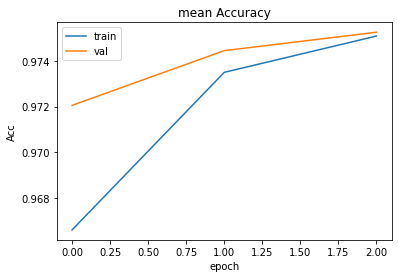

In [33]:
plt.plot(np.sqrt(accs))
plt.plot(np.sqrt(accs_eval))
plt.title('mean Accuracy')
plt.ylabel('Acc')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [34]:
preds = []
targets = []
for texts, ys in valid_generator:
    preds += model(texts.to(device)).squeeze().detach().to('cpu').numpy().tolist()
    targets += ys.numpy().tolist()

In [35]:
# можно подбирать порог для отнесения к токсичному классу
print(classification_report(targets, (np.array(preds) > 0.25).astype(int)))

              precision    recall  f1-score   support

         0.0       0.97      0.97      0.97     61262
         1.0       0.57      0.61      0.59      4045

    accuracy                           0.95     65307
   macro avg       0.77      0.79      0.78     65307
weighted avg       0.95      0.95      0.95     65307



Большой разницы как будто бы нет, но получается что лучше всего суммировать

Добавим фасттекст и вордтувек

In [54]:
from gensim.models import FastText
from gensim.models import Word2Vec

In [55]:
texts = train_dataset['question_text'].apply(preprocess).tolist()

In [56]:
%%time
ft = FastText(texts, vector_size=100, epochs=3)

CPU times: user 5min 35s, sys: 1.08 s, total: 5min 36s
Wall time: 2min 57s


In [57]:
%%time
w2v = Word2Vec(texts, vector_size=100, epochs=3)

CPU times: user 1min 47s, sys: 513 ms, total: 1min 48s
Wall time: 58.8 s


In [58]:
weights_ft = np.zeros((len(word2id), 100))
weights_w2v = np.zeros((len(word2id), 100))

for word, i in word2id.items():
    # вектор паддинга оставим нулевым
    if word == 'PAD':
        continue
    
    try:
        weights_ft[i] = ft.wv[word]
        weights_w2v[i] = w2v.wv[word]
    
    
    except KeyError:
        # для слов, которых нет в модели тоже возьмем какой-то  рандомный вектор
        weights_ft[i] = ft.wv['опрагпллирао']
        weights_w2v[i] = w2v.wv['опрагпллирао']

кажется объединять эмбеддинги на уровне словаря было бы удобнее

In [59]:
class Clf(nn.Module):
    
    def __init__(self, vocab_size, embedding_dim, output_dim, embeddings_weights_1, embeddings_weights_2, emb_type='flatten'):
        
        super().__init__()          
        self.embedding_1 = nn.Embedding(vocab_size, embedding_dim)
        self.embedding_1.from_pretrained(torch.tensor(embeddings_weights_1), freeze=True)
        self.embedding_2 = nn.Embedding(vocab_size, embedding_dim)
        self.embedding_2.from_pretrained(torch.tensor(embeddings_weights_2), freeze=True)
        self.hidden, linear_input_dim = my_layer(embedding_dim, emb_type)
        self.fc = nn.Linear(linear_input_dim, output_dim)
        self.act = nn.Sigmoid() # активацию менять даже не пришлось, так как у нас бинарная классификация
                                # если классов больше 2, то нужно поставить nn.Softmax()
        
    def forward(self, text):
        
        embedded_1 = self.embedding_1(text)
        embedded_2 = self.embedding_2(text)
        # в этом месте объединяем модели
        if flag == True:
          embedded = torch.cat((embedded_1, embedded_2), dim=1)

        else:
          embedded = (embedded_1 + embedded_2)/2
        hidden = self.hidden(embedded)
        dense_outputs=self.fc(hidden)
        outputs=self.act(dense_outputs)
        
        return outputs

запускаем с конкатенацией

In [60]:
flag = True

In [61]:
import torch.optim as optim

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  
model = Clf(len(word2id), 30, 1, weights_ft, weights_w2v, emb_type='sum')

optimizer = optim.Adam(model.parameters(), lr=0.0005)
criterion = nn.BCELoss() # другой лосс - Binary cross-entropy

model = model.to(device)
criterion = criterion.to(device)

sum


In [62]:
%%time
accs = []
accs_eval = []
epochs = 3
for i in range(epochs):
    print(i)
    accs.append(train(model, training_generator, optimizer, criterion))
    accs_eval.append(evaluate(model, valid_generator, criterion))

0
Loss: 0.26713044113583034; Accuracy: 0.9295350037537538
Loss: 0.22234039219574311; Accuracy: 0.9352860023761881
Loss: 0.20059270192609702; Accuracy: 0.938488610786929
Loss: 0.18696969530863533; Accuracy: 0.9408426325331333
1
Loss: 0.13468406399016505; Accuracy: 0.9517720845845846
Loss: 0.1329108247307016; Accuracy: 0.951522636318159
Loss: 0.13214708381233392; Accuracy: 0.9515098782927642
Loss: 0.13102279315816964; Accuracy: 0.9517310968367092
2
Loss: 0.12550141551607363; Accuracy: 0.9540829892392393
Loss: 0.12465774547448452; Accuracy: 0.9535998467983992
Loss: 0.12466718950602323; Accuracy: 0.9533060499333111
Loss: 0.12418821259725688; Accuracy: 0.9534239028507127
CPU times: user 1min 53s, sys: 5.95 s, total: 1min 59s
Wall time: 1min 59s


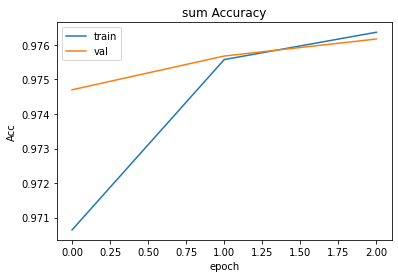

In [63]:
plt.plot(np.sqrt(accs))
plt.plot(np.sqrt(accs_eval))
plt.title('sum Accuracy')
plt.ylabel('Acc')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [64]:
preds = []
targets = []
for texts, ys in valid_generator:
    preds += model(texts.to(device)).squeeze().detach().to('cpu').numpy().tolist()
    targets += ys.numpy().tolist()

In [65]:
print(classification_report(targets, (np.array(preds) > 0.2).astype(int)))

              precision    recall  f1-score   support

         0.0       0.98      0.95      0.97     61262
         1.0       0.51      0.74      0.60      4045

    accuracy                           0.94     65307
   macro avg       0.74      0.85      0.78     65307
weighted avg       0.95      0.94      0.94     65307



стало лучше

и со средним

In [66]:
flag = False

In [67]:
import torch.optim as optim

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  
model = Clf(len(word2id), 30, 1, weights_ft, weights_w2v, emb_type='sum')

optimizer = optim.Adam(model.parameters(), lr=0.0005)
criterion = nn.BCELoss() # другой лосс - Binary cross-entropy

model = model.to(device)
criterion = criterion.to(device)

sum


In [68]:
%%time
accs = []
accs_eval = []
epochs = 3
for i in range(epochs):
    print(i)
    accs.append(train(model, training_generator, optimizer, criterion))
    accs_eval.append(evaluate(model, valid_generator, criterion))

0
Loss: 0.25122621366838077; Accuracy: 0.9309152902902903
Loss: 0.20937010342848783; Accuracy: 0.9368746873436719
Loss: 0.18984960031264939; Accuracy: 0.9400177663387796
Loss: 0.17792255266714643; Accuracy: 0.941963029819955
1
Loss: 0.13282275487770429; Accuracy: 0.9516626001001001
Loss: 0.131328832300351; Accuracy: 0.9514229771135568
Loss: 0.13040939498495244; Accuracy: 0.9514382398299434
Loss: 0.12940469357364623; Accuracy: 0.9516285321330332
2
Loss: 0.12419812415947427; Accuracy: 0.954028246996997
Loss: 0.12363048806309461; Accuracy: 0.9535392696348174
Loss: 0.12337125469248825; Accuracy: 0.9533815959486496
Loss: 0.12296564975871269; Accuracy: 0.953459067891973
CPU times: user 1min 51s, sys: 5.35 s, total: 1min 56s
Wall time: 1min 57s


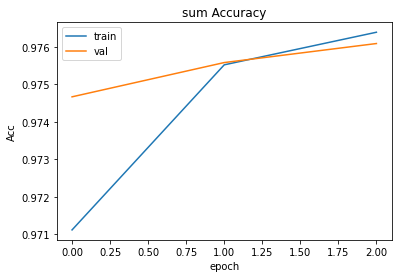

In [69]:
plt.plot(np.sqrt(accs))
plt.plot(np.sqrt(accs_eval))
plt.title('sum Accuracy')
plt.ylabel('Acc')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [70]:
preds = []
targets = []
for texts, ys in valid_generator:
    preds += model(texts.to(device)).squeeze().detach().to('cpu').numpy().tolist()
    targets += ys.numpy().tolist()

In [71]:
print(classification_report(targets, (np.array(preds) > 0.2).astype(int)))

              precision    recall  f1-score   support

         0.0       0.98      0.96      0.97     61262
         1.0       0.54      0.71      0.61      4045

    accuracy                           0.94     65307
   macro avg       0.76      0.83      0.79     65307
weighted avg       0.95      0.94      0.95     65307



со склеиванием результаты были лучше